In [ ]:
#@title Copyright 2020, 2021 Alina Wróblewska { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tagowanie

## CHANGELOG

20.04.2021 zmiany zostały oznaczone:


*   OUTDATED: nieaktualne informacje
*   UPDATE: aktualne modyfikacje



In [1]:
# W folerze 'zasoby' będą pobrane zasoby, tzn. dane, modele, 
# a do pozostałych folderów będą wpisywane predykcje.
import os
os.makedirs('zasoby', exist_ok=True)
os.makedirs('predykcje', exist_ok=True)
os.makedirs('predykcje/segmentatacja_gold', exist_ok=True)

### UPDATE! Instalacja COMBO


In [6]:
# Instalacja COMBO
!pip install -U pip setuptools wheel
!pip install --index-url https://pypi.clarin-pl.eu/simple combo==1.0.3

     |████████████████████████████████| 1.5MB 7.2MB/s 
     |████████████████████████████████| 788kB 32.1MB/s 
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Found existing installation: setuptools 54.2.0
    Uninstalling setuptools-54.2.0:
      Successfully uninstalled setuptools-54.2.0


Looking in indexes: https://pypi.clarin-pl.eu/simple
     |████████████████████████████████| 70 kB 220 kB/s 
     |████████████████████████████████| 506 kB 7.4 MB/s 
     |████████████████████████████████| 104 kB 16.2 MB/s 
     |████████████████████████████████| 127 kB 15.7 MB/s 
     |████████████████████████████████| 1.0 MB 15.9 MB/s 
     |████████████████████████████████| 59 kB 7.3 MB/s 
     |████████████████████████████████| 255 kB 35.3 MB/s 
     |████████████████████████████████| 14.5 MB 78 kB/s 
     |████████████████████████████████| 748.8 MB 15 kB/s 
     |████████████████████████████████| 1.4 MB 72.4 MB/s 
     |████████████████████████████████| 120 kB 72.5 MB/s 
     |████████████████████████████████| 131 kB 71.2 MB/s 
     |████████████████████████████████| 2.9 MB 67.6 MB/s 
     |████████████████████████████████| 895 kB 46.7 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 7.4 MB 58.1 MB/s 
  Created wheel for absl-py

In [1]:
# Test, czy COMBO został poprawnie zainstalowany
!combo --helpfull

2021-04-20 15:00:30.811375: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)

       USAGE: /usr/local/bin/combo [flags]
flags:

absl.app:
  -?,--[no]help: show this help
    (default: 'false')
  --[no]helpfull: show full help
    (default: 'false')
  --[no]helpshort: show this help
    (default: 'false')
  --[no]helpxml: like --helpfull, but generates XML output
    (default: 'false')
  --[no]only_check_args: Set to true to validate args and exit.
    (default: 'false')
  -

## Przetwarzania plików CoNLL-U


Format CoNLL-U:
*   każdemu segmentowi odpowiada jedna linia,
*   zdania oddzielone są pustymi liniami,
*   każde zdanie poprzedzone jest metadanymi zapisanymi w liniach rozpoczynających się znakiem `#`,
*   w przypadku segmentów składających się z kilku wyrazów (np. im --> in dem w niemieckim) występuje dodatkowa linia odpowiadająca temu słowu,
*   linia zawierająca opis pojedynczego segmentu składa się z 10 kolumn:
 1.   ID: numer kolejny słowa w zdaniu,
 2.   ORTH: forma tekstowa,
 3.   **LEMMA**: lemat,
 4. **UPOS**: [uniwersalna część mowy](https://universaldependencies.org/u/pos/index.html),
 5. **XPOS**: tag właściwy dla danego języka,
 6. **UFEATS**: [uniwersalne cechy morfologiczne](https://universaldependencies.org/u/feat/index.html),
 7. HEAD: id nadrzędnika,
 8. DEPREL: etykieta relacji zależnościowej.

Do przetwarzania/zwracania plików w formacie CoNLL-U wykorzystamy bibliotekę [spacy-conll](https://pypi.org/project/spacy-conll/).

In [ ]:
# UPDATE! COMBO instaluje tę wersję spaCy, więc ten krok nie jest już konieczny
#!pip install spacy==2.3.2

In [4]:
# Pobranie podstawowego modelu spaCy
!python -m spacy download pl_core_news_sm

     |████████████████████████████████| 48.7 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_sm')


Uruchom ponownie środowisko wykonawcze!

In [2]:
# Wczytanie modelu podstawowego spaCy
import spacy
nlp = spacy.load("pl_core_news_sm")

In [3]:
# Przetworzenie zdania
doc = nlp("To jest słoń, którego sfotografowaliśmy.")

In [4]:
print("{:20} {:20} {:20}".format('SEGMENT', 'LEMAT', 'UPOS'))
for token in doc:
    print("{:20} {:20} {:20}".format(token.text, token.lemma_, token.pos_))

SEGMENT              LEMAT                UPOS                
To                   to                   VERB                
jest                 być                  VERB                
słoń                 słoń                 NOUN                
,                    ,                    PUNCT               
którego              który                ADJ                 
sfotografowaliśmy    sfotografować        VERB                
.                    .                    PUNCT               


In [5]:
doc = nlp("Tośmy sfotografowali słonia!")
print("{:20} {:20} {:20}".format('SEGMENT', 'LEMAT', 'UPOS'))
for token in doc:
    print("{:20} {:20} {:20}".format(token.text, token.lemma_, token.pos_))

SEGMENT              LEMAT                UPOS                
Tośmy                tośmy                NOUN                
sfotografowali       sfotografować        VERB                
słonia               słoń                 NOUN                
!                    !                    PUNCT               


In [6]:
# Instalacja biblioteki spacy-conll do przetwarzania plików conll
! pip install spacy-conll

Biblioteka ```spacy-conll``` umożliwia przetwarzanie wstępnie posegmentowanych plików:

Funkcja ```init_parser``` do inicjowania parsera akceptuje wstępnie posegmentowane wejście (```is_tokenized=True```)

In [7]:
from spacy_conll import init_parser
nlp = init_parser('spacy', 'pl_core_news_sm', is_tokenized=True)

In [8]:
doc = nlp('To jest słoń , którego sfotografowali śmy .')

In [9]:
print("{:20} {:20} {:20}".format('SEGMENT', 'LEMAT', 'UPOS'))
for token in doc:
    print("{:20} {:20} {:20}".format(token.text, token.lemma_, token.pos_))

SEGMENT              LEMAT                UPOS                
To                   to                   VERB                
jest                 być                  VERB                
słoń                 słoń                 NOUN                
,                    ,                    PUNCT               
którego              który                ADJ                 
sfotografowali       sfotografować        VERB                
śmy                  być                  AUX                 
.                    .                    PUNCT               


In [10]:
doc = nlp('To śmy sfotografowali słonia !')
print("{:20} {:20} {:20}".format('SEGMENT', 'LEMAT', 'UPOS'))
for token in doc:
    print("{:20} {:20} {:20}".format(token.text, token.lemma_, token.pos_))

SEGMENT              LEMAT                UPOS                
To                   to                   PART                
śmy                  być                  AUX                 
sfotografowali       sfotografować        VERB                
słonia               słoń                 NOUN                
!                    !                    PUNCT               


Przy pomocy skryptu uruchamianego z wiersza poleceń ```parse-as-conll``` można przetworzyć string albo plik tekstowy i wpisać wynik do pliku CoNLL.

In [11]:
!parse-as-conll --model_or_lang 'pl_core_news_sm' --input_str 'To jest słoń, którego sfotografowaliśmy.' --output_file 'test.conllu' --include_headers

In [12]:
! head test.conllu

# sent_id = 1
# text = To jest słoń, którego sfotografowaliśmy.
1	To	to	VERB	PRED	_	0	ROOT	_	_
2	jest	być	VERB	FIN	_	1	aux	_	_
3	słoń	słoń	NOUN	SUBST	_	1	nsubj	_	SpaceAfter=No
4	,	,	PUNCT	INTERP	_	6	punct	_	_
5	którego	który	ADJ	ADJ	_	6	obj	_	_
6	sfotografowaliśmy	sfotografować	VERB	PRAET	_	3	acl	_	SpaceAfter=No
7	.	.	PUNCT	INTERP	_	1	punct	_	SpaceAfter=No


In [13]:
! wget -P zasoby http://mozart.ipipan.waw.pl/~alina/zasoby/data/PDBUD_test.txt

--2021-04-20 15:06:26--  http://mozart.ipipan.waw.pl/~alina/zasoby/data/PDBUD_test.txt
Resolving mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)... 213.135.36.148
Connecting to mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)|213.135.36.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208260 (203K) [text/plain]
Saving to: ‘zasoby/PDBUD_test.txt’

PDBUD_test.txt      100%[===================>] 203.38K   321KB/s    in 0.6s    

2021-04-20 15:06:27 (321 KB/s) - ‘zasoby/PDBUD_test.txt’ saved [208260/208260]



In [14]:
!head -n 10 zasoby/PDBUD_test.txt

Mężczyzna w czapce kuca na chodniku pod ścianą budynku, a koło niego jest pięć kotów.
Chłopak biegnie, asekurując jadącego obok rowerem chłopca w kasku na głowie.
Kilkanaście dziewczynek w białych sukienkach i kokardach na głowie stoi obok siebie na scenie.
Uśmiechnięta dziewczynka o jasnych włosach zjeżdża na zjeżdżalni.
Jasnowłose dziecko jedzie po chodniku na czerwonej hulajnodze.
Brudny samochód terenowy stoi zapadnięty w błocie.
Dwaj mężczyźni z wędkami stoją na plaży w pobliżu łodzi.
Dwie osoby skaczą nad śniegiem na deskach snowboardowych w pobliżu drewnianych budynków.
Małpa stoi zwrócona w kierunku innej skaczącej w jej stronę małpy.
Na boisku trzech piłkarzy podskakuje do piłki podczas meczu.


In [15]:
! time parse-as-conll --model_or_lang 'pl_core_news_sm' --input_file 'zasoby/PDBUD_test.txt' --output_file 'predykcje/PDBUD_test_spaCy_baseline.conllu' --include_headers


real	0m18.370s
user	0m16.961s
sys	0m1.480s


In [16]:
! tail -n 50 predykcje/PDBUD_test_spaCy_baseline.conllu

2	się	się	PART	QUB	_	1	expl:pv	_	SpaceAfter=No
3	,	,	PUNCT	INTERP	_	5	punct	_	_
4	że	że	SCONJ	COMP	_	5	mark	_	_
5	przemówił	przemówić	VERB	PRAET	_	1	ccomp	_	_
6	tu	tu	ADV	ADV	_	5	advmod	_	_
7	dziś	dziś	ADV	ADV	_	8	advmod	_	_
8	prawdziwy	prawdziwy	ADJ	ADJ	_	10	amod	_	_
9	socjaldemokratyczny	socjaldemokratyczny	ADJ	ADJ	_	10	amod	_	_
10	szef	szef	NOUN	SUBST	_	5	nsubj	_	_
11	rządu	rząd	NOUN	SUBST	_	10	nmod	_	SpaceAfter=No
12	.	.	PUNCT	INTERP	_	1	punct	_	SpaceAfter=No

# sent_id = 2415
# text = Chciałbym podziękować swojemu oponentowi, panu Bushill-Matthewsowi za profesjonalny sposób przewodniczenia negocjacjom, koleżankom i kolegom z innych grup za ich pomoc pod względem politycznym, a prezydencji francuskiej za jej wyrafinowane podejście.
1	Chciałbym	chciałbym	ADJ	ADJ	_	0	ROOT	_	_
2	podziękować	podziękować	VERB	INF	_	1	xcomp	_	_
3	swojemu	swój	ADJ	ADJ	_	4	amod	_	_
4	oponentowi	oponent	NOUN	SUBST	_	2	obj	_	SpaceAfter=No
5	,	,	PUNCT	INTERP	_	7	punct	_	_
6	panu	pan	NOUN	SUBST	_	7	nsubj	_	_
7

# Analizator morfologiczny [Morfeusz](http://morfeusz.sgjp.pl) w Pythonie
*   analizator i generator morfologiczny opracowany w IPI PAN
*   wersja demo: http://morfeusz.sgjp.pl/demo
*   można go wbudować w tworzone programy
*   przy pomocy dodatkowych modułów można go użyć z poziomu Pythona i Javy
*   dystrybuowany z dwoma słownikami: SGJP lub Polimorf
*   Tutorial Morfeusza (K. Krasnowska-Kieraś): http://clarin-pl.eu/wp-content/uploads/2019/10/Morfeusz2.pdf



### Instalacja
Instalujemy bibliotekę pythonową Morfeusza z pakietów Ubuntu ([instalacja dla innych systemów](http://morfeusz.sgjp.pl/download/))

In [17]:
!wget -O - http://download.sgjp.pl/apt/sgjp.gpg.key|sudo apt-key add -
!sudo apt-add-repository http://download.sgjp.pl/apt/ubuntu
!sudo apt update
!sudo apt install libmorfeusz2
!sudo apt install python3-morfeusz2
!wget http://download.sgjp.pl/morfeusz/20210221/Linux/18.04/64/morfeusz2-1.9.17-cp37-cp37m-linux_x86_64.whl -O morfeusz2-1.9.17-cp37-cp37m-linux_x86_64.whl
!python3 -m pip install --upgrade --force-reinstall morfeusz2-1.9.17-cp37-cp37m-linux_x86_64.whl

--2021-04-20 15:07:03--  http://download.sgjp.pl/apt/sgjp.gpg.key
Resolving download.sgjp.pl (download.sgjp.pl)... 193.0.67.154
Connecting to download.sgjp.pl (download.sgjp.pl)|193.0.67.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/pgp-keys]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.00K  --.-KB/s    in 0s      

2021-04-20 15:07:03 (197 MB/s) - written to stdout [1029/1029]

OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/comput

### Klasa `Morfeusz`
Biblioteka `morfeusz2` udostępnia klasę `Morfeusz` implementującą analizator i generator morfologiczny ([dokumentacja](http://sgjp.pl/morfeusz/download/Morfeusz2.pdf)).

In [18]:
import morfeusz2
m = morfeusz2.Morfeusz()

### Analiza morfologiczna

In [19]:
for a in m.analyse('Kolo pojechał na wakacje do Włoch autostopem.'):
    print(a)

(0, 1, ('Kolo', 'kolo', 'subst:sg:nom:m1', ['nazwa_pospolita'], ['pot.']))
(0, 1, ('Kolo', 'kolo', 'subst:sg:voc:m1', ['nazwa_pospolita'], ['pot.']))
(0, 1, ('Kolo', 'Kolo:s1', 'subst:sg:nom:m1', ['nazwisko'], []))
(0, 1, ('Kolo', 'Kolo:s1', 'subst:sg:voc:m1', ['nazwisko'], []))
(0, 1, ('Kolo', 'Kolo:s2', 'subst:sg.pl:nom.gen.dat.acc.inst.loc.voc:f', ['nazwisko'], []))
(0, 1, ('Kolo', 'kola', 'subst:sg:voc:f', ['nazwa_pospolita'], []))
(1, 2, ('pojechał', 'pojechać', 'praet:sg:m1.m2.m3:perf', [], []))
(2, 3, ('na', 'na:p', 'prep:acc', [], []))
(2, 3, ('na', 'na:p', 'prep:loc', [], []))
(2, 3, ('na', 'na:i', 'interj', [], []))
(3, 4, ('wakacje', 'wakacje', 'subst:pl:nom.acc.voc:n:pt', ['nazwa_pospolita'], []))
(4, 5, ('do', 'do:s', 'subst:sg.pl:nom.gen.dat.acc.inst.loc.voc:n:ncol', ['nazwa_pospolita'], ['muz.']))
(4, 5, ('do', 'do:p', 'prep:gen', [], []))
(5, 6, ('Włoch', 'Włoch:s1', 'subst:sg:nom:m1', ['nazwa_pospolita'], []))
(5, 6, ('Włoch', 'Włoch:s2', 'subst:sg:nom:m1', ['nazwisko'

Graf analizy morfologicznej reprezentowany jest jako lista krotek (`tuple`) . Każda krotka zawiera:
 * indeks początku segmentu w grafie,
 * indeks końca segmentu w grafie,
 * interpretację morfologiczną (zagnieżdżoną krotkę):
   * formę tekstową,
   * lemat,
   * tag (znacznik morfologiczny),
   * kategorię nazw własnych,
   * listę kwalifikatorów stylistycznych i dziedzinowych.

Morfeusz domyślnie używa „spakowanej” notacji dla znaczników. Np. `praet:sg:m1.m2.m3:perf` należy odczytać jako skrót dla wszystkich kombinacji wartości oddzielonych kropkami na poszczególnych pozycjach:
  * `praet:sg:m1:perf`
  * `praet:sg:m2:perf`
  * `praet:sg:m3:perf`

### Generowanie morfologiczne

In [20]:
print("Lista form wyrazowych lematu brat:")
for g in m.generate('brat'):
    print(g)

Lista form wyrazowych lematu brat:
('brat', 'brat', 'subst:sg:nom:m1', ['nazwa_pospolita'], [])
('brata', 'brat', 'subst:sg:gen.acc:m1', ['nazwa_pospolita'], [])
('bratu', 'brat', 'subst:sg:dat:m1', ['nazwa_pospolita'], [])
('bratem', 'brat', 'subst:sg:inst:m1', ['nazwa_pospolita'], [])
('bracie', 'brat', 'subst:sg:loc:m1', ['nazwa_pospolita'], [])
('bracie', 'brat', 'subst:sg:voc:m1', ['nazwa_pospolita'], [])
('bracia', 'brat', 'subst:pl:nom.voc:m1', ['nazwa_pospolita'], [])
('braci', 'brat', 'subst:pl:gen.acc:m1', ['nazwa_pospolita'], [])
('braciom', 'brat', 'subst:pl:dat:m1', ['nazwa_pospolita'], [])
('braćmi', 'brat', 'subst:pl:inst:m1', ['nazwa_pospolita'], [])
('braciach', 'brat', 'subst:pl:loc:m1', ['nazwa_pospolita'], [])
('braty', 'brat', 'depr:pl:nom.acc.voc:m2', ['nazwa_pospolita'], [])
('b', 'brat', 'brev:pun', [], [])


#  Model morfeuszowy spaCy dla polskiego

*   Wymaga zainstalowania biblioteki Morfeusz2
*   Tagi i lemmaty zwracane przez Morfeusza są ujednoznaczniane przez tager Toygger
*   Modele morfeuszowe spaCy dla polskiego dostępne są na http://zil.ipipan.waw.pl/SpacyPL
*   Notatnik z instruktarzem: https://nbviewer.jupyter.org/github/ipipan/spacy-pl/blob/master/spaCy_PL_morfeusz_demo.ipynb



### Instalacja

In [21]:
! wget -P zasoby http://mozart.ipipan.waw.pl/~alina/zasoby/data/pl_spacy_model_morfeusz-0.1.3.tar.gz

--2021-04-20 15:08:45--  http://mozart.ipipan.waw.pl/~alina/zasoby/data/pl_spacy_model_morfeusz-0.1.3.tar.gz
Resolving mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)... 213.135.36.148
Connecting to mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)|213.135.36.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229068993 (218M) [application/x-gzip]
Saving to: ‘zasoby/pl_spacy_model_morfeusz-0.1.3.tar.gz’

pl_spacy_model_morf 100%[===================>] 218.46M  17.6MB/s    in 29s     

2021-04-20 15:09:14 (7.47 MB/s) - ‘zasoby/pl_spacy_model_morfeusz-0.1.3.tar.gz’ saved [229068993/229068993]



In [22]:
! python -m pip install zasoby/pl_spacy_model_morfeusz-0.1.3.tar.gz

Processing ./zasoby/pl_spacy_model_morfeusz-0.1.3.tar.gz
     |████████████████████████████████| 180 kB 8.0 MB/s 
     |████████████████████████████████| 320.4 MB 25 kB/s 
     |████████████████████████████████| 459 kB 74.0 MB/s 
     |████████████████████████████████| 20.1 MB 139 kB/s 
  Created wheel for pl-spacy-model-morfeusz: filename=pl_spacy_model_morfeusz-0.1.3-py3-none-any.whl size=229138613 sha256=df4dcf32fefec4b7f880a895002baab80f658479ed39f27b5f2aca2623a0730f
  Stored in directory: /root/.cache/pip/wheels/df/b6/82/18e0acf4596de00048b8b72d620269bc1e68c885f761687417
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16260 sha256=b2d1f2c2440d4fa079568edf8a8ffd86b90493bebf19c29e973a3a955240e5a7
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built pl-spacy-model-morfeusz distance
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.

In [23]:
!python3 -m spacy link pl_spacy_model_morfeusz pl_spacy_model_morfeusz

2021-04-20 15:11:07.330350: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pl_spacy_model_morfeusz -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pl_spacy_model_morfeusz
You can now load the model via spacy.load('pl_spacy_model_morfeusz')


### Predykcja

In [24]:
import spacy
nlp = spacy.load("pl_spacy_model_morfeusz")

In [25]:
doc = nlp("To jest słoń, którego sfotografowaliśmy.")

In [26]:
# Atrubuty tokenów https://spacy.io/api/token
print("{:15} {:15} {:15} {:15}".format('SEGMENT', 'LEMAT', 'UPOS', 'TAG'))
for token in doc:
    print("{:15} {:15} {:15} {:15}".format(token.text, token.lemma_, token.pos_, ':'.join([token.tag_, token._.feats]).rstrip(":")))

SEGMENT         LEMAT           UPOS            TAG            
To              to              VERB            pred           
jest            być             VERB            fin:sg:ter:imperf
słoń            słoń            NOUN            subst:sg:nom:m2
,               ,               PUNCT           interp         
którego         który           ADJ             adj:sg:acc:m2:pos
sfotografowali  sfotografować   VERB            praet:pl:m1:perf
śmy             być             AUX             aglt:pl:pri:imperf:nwok
.               .               PUNCT           interp         


In [27]:
doc2 = nlp("Tośmy sfotografowali słonia!")
print("{:15} {:15} {:15} {:15}".format('SEGMENT', 'LEMAT', 'UPOS', 'TAG'))
for token in doc2:
    print("{:15} {:15} {:15} {:15}".format(token.text, token.lemma_, token.pos_, ':'.join([token.tag_, token._.feats]).rstrip(":")))

SEGMENT         LEMAT           UPOS            TAG            
To              to              SCONJ           comp           
śmy             być             AUX             aglt:pl:pri:imperf:nwok
sfotografowali  sfotografować   VERB            praet:pl:m1:perf
słonia          słoń            NOUN            subst:sg:acc:m2
!               !               PUNCT           interp         


In [28]:
!parse-as-conll --model_or_lang 'pl_spacy_model_morfeusz' --input_file 'zasoby/PDBUD_test.txt' --output_file 'predykcje/PDBUD_test_spaCy_Morfeusz.conllu' --include_headers

2021-04-20 15:16:51.940808: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-20 15:16:55.201370: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-20 15:16:55.209261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-20 15:16:55.210346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-04-20 15:16:55.210402: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-20 15:16:55.210470: I tensorflow/stream_executor/platform/default

In [29]:
!head -n 50 predykcje/PDBUD_test_spaCy_Morfeusz.conllu

# sent_id = 1
# text = Mężczyzna w czapce kuca na chodniku pod ścianą budynku, a koło niego jest pięć kotów.
1	Mężczyzna	mężczyzna	NOUN	subst	_	4	nsubj	_	_
2	w	w	ADP	prep	_	3	case	_	_
3	czapce	czapka	NOUN	subst	_	1	nmod	_	_
4	kuca	kucać	VERB	fin	_	0	ROOT	_	_
5	na	na	ADP	prep	_	6	case	_	_
6	chodniku	chodnik	NOUN	subst	_	4	obl	_	_
7	pod	pod	ADP	prep	_	8	case	_	_
8	ścianą	ściana	NOUN	subst	_	4	obl	_	_
9	budynku	budynek	NOUN	subst	_	8	nmod	_	SpaceAfter=No
10	,	,	PUNCT	interp	_	14	punct	_	_
11	a	a	CCONJ	conj	_	14	cc	_	_
12	koło	koło	ADP	prep	_	13	case	_	_
13	niego	on	PRON	ppron3	_	14	obl	_	_
14	jest	być	VERB	fin	_	4	conj	_	_
15	pięć	pięć	NUM	num	_	16	nummod:gov	_	_
16	kotów	kot	NOUN	subst	_	14	nsubj	_	SpaceAfter=No
17	.	.	PUNCT	interp	_	4	punct	_	SpaceAfter=No

# sent_id = 2
# text = Chłopak biegnie, asekurując jadącego obok rowerem chłopca w kasku na głowie.
1	Chłopak	chłopak	NOUN	subst	_	2	nsubj	_	_
2	biegnie	biec	VERB	fin	_	0	ROOT	_	SpaceAfter=No
3	,	,	PUNCT	interp	_	4	punct	_	_
4	asekur

# COMBO

*  COMBO to niezależny od języka system wstępnego przetwarzania języka naturalnego, który wykorzystuje algorytmy sieci neuronowych.
*  Moduły COMBO:
 * tager (predykcja uniwersalnych części mowy i specyficznych dla języka tagów),
 * analizator morfologiczny (predykcja list cech gramatycznych), 
 * lematyzator (predykcja lematów),
 * parser zależnościowy (predykcja krawędzi w drzewie i etykiet, tj. typów relacji zależnościowych),
 * moduł etykietowania ról semantycznych (predykcja ról semantycznych, np. Time, Place, Recipient),
 * moduł obliczanie zanurzeń zdań (ang. sentence embeddings).
*  OUTDATED! https://github.com/ipipan/combo
*  https://gitlab.clarin-pl.eu/syntactic-tools/combo
*  Zalety COMBO:
 *  łatwy do instalacji pakiet Pythonowy oparty na platformie AllenNLP i bibliotece PyTorch,
 *  łatwy do konfigurowania system, który umożliwia trenowanie modeli różniących się zakresem cech wejściowych, zakresem predykcji, rodzajem reprezentowania danych wejściowych (np. zanurzenia typu fastText, BERT),
 *  pozwala na trenowanie modeli na bankach drzew zależnościowych w formacie CoNLL (drzewa mogą być zaanotowane zgodnie ze schematem UD albo innym, specyficznym dla języka),
 *  system typu end-to-end z równocześnie trenowanymi modułami predykcyjnymi, dlatego trenowanie COMBO jest znacznie szybsze niż ,,potokowe” trenowanie systemów (np. Stanza).

### UPDATE! Instalacja

*   Aktualizacja sposobu instalowania COMBO
*   Aktualizacja sposobu pobierania modeli
*   Lista dostępnych modeli jest tutaj https://gitlab.clarin-pl.eu/syntactic-tools/combo/-/blob/master/docs/performance.md
*   System COMBO jest ciągle udoskonalany. Najbardziej aktualnym źródłem informacji jest repozytorium projektowe COMBO https://gitlab.clarin-pl.eu/syntactic-tools/combo/-/tree/master



In [ ]:
# Pobieramy instalację COMBO skompilowaną w środowisku wirtualnym
# OUTDATED !wget -P zasoby http://mozart.ipipan.waw.pl/~alina/zasoby/data/COMBO-0.0.1.tar.gz 

In [ ]:
# OUTDATED !python -m pip install urllib3==1.25.11

In [ ]:
#  OUTDATED! python -m pip install zasoby/COMBO-0.0.1.tar.gz

In [ ]:
# Pythonowa wersja COMBO, która jest zintegrowana z modelem segmentacji spaCy dla angielskiego (dzieli po spacjach)
# OUTDATED import combo.predict as predict

In [ ]:
# Wczytujemy model COMBO wspomagany kontekstowymi zanurzeniami słownymi z modelu HerBERT https://huggingface.co/allegro/herbert-base-cased
# OUTDATED nlp = predict.SemanticMultitaskPredictor.from_pretrained("polish-herbert-base")

In [30]:
# UPDATE Import pakietu COMBO
from combo.predict import COMBO

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [31]:
# UPDATE Pobranie modelu przy pomocy metody from_pretrained
# Należy podać nazwę wybranego modelu.
# Jeśli nie ma GPU, to cuda_device=-1
# Model polish-herbert-base jest wspomagany kontekstowymi zanurzeniami typu BERT
combo = COMBO.from_pretrained("polish-herbert-base", cuda_device=0)

100%|██████████| 323M/323M [00:25<00:00, 13.2MB/s]


In [32]:
sentence = combo("To jest słoń, którego sfotografowaliśmy.")

In [33]:
print("{:20} {:20} {:15} {:20} {:15}".format('SEGMENT', 'LEMAT', 'UPOS', 'XPOS', 'FEATS'))
for token in sentence.tokens:
    print("{:20} {:20} {:15} {:20} {:15}".format(token.token, token.lemma, token.upostag, token.xpostag, token.feats))

SEGMENT              LEMAT                UPOS            XPOS                 FEATS          
To                   to                   AUX             pred                 Mood=Ind|Tense=Pres|VerbForm=Fin|VerbType=Quasi
jest                 być                  AUX             fin:sg:ter:imperf    Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act
słoń                 słoń                 NOUN            subst:sg:nom:m2      Animacy=Nhum|Case=Nom|Gender=Masc|Number=Sing
,                    ,                    PUNCT           interp               PunctType=Comm 
którego              który                DET             adj:sg:acc:m1:pos    Animacy=Nhum|Case=Acc|Gender=Masc|Number=Sing|PronType=Rel
sfotografowaliśmy    sfotografowalis      VERB            fin:pl:pri:perf      Aspect=Perf|Mood=Ind|Number=Plur|Person=1|Tense=Fut|VerbForm=Fin|Voice=Act
.                    .                    PUNCT           interp               PunctType=Peri 


Konsolowa wersja COMBO wymaga pobrania modelu COMBO

In [34]:
# model COMBO 
! wget -P zasoby http://mozart.ipipan.waw.pl/~mklimaszewski/models/polish-herbert-base.tar.gz

--2021-04-20 15:29:36--  http://mozart.ipipan.waw.pl/~mklimaszewski/models/polish-herbert-base.tar.gz
Resolving mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)... 213.135.36.148
Connecting to mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)|213.135.36.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338807742 (323M) [application/x-gzip]
Saving to: ‘zasoby/polish-herbert-base.tar.gz’

polish-herbert-base 100%[===================>] 323.11M  17.6MB/s    in 32s     

2021-04-20 15:30:09 (10.0 MB/s) - ‘zasoby/polish-herbert-base.tar.gz’ saved [338807742/338807742]



In [35]:
# korpus wzorcowy
! wget -P zasoby http://mozart.ipipan.waw.pl/~alina/zasoby/data/PDBUD_test.conllu

--2021-04-20 15:30:12--  http://mozart.ipipan.waw.pl/~alina/zasoby/data/PDBUD_test.conllu
Resolving mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)... 213.135.36.148
Connecting to mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)|213.135.36.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3486186 (3.3M)
Saving to: ‘zasoby/PDBUD_test.conllu’

PDBUD_test.conllu   100%[===================>]   3.32M  2.66MB/s    in 1.2s    

2021-04-20 15:30:14 (2.66 MB/s) - ‘zasoby/PDBUD_test.conllu’ saved [3486186/3486186]



In [36]:
!combo --mode predict --model_path zasoby/polish-herbert-base.tar.gz --input_file zasoby/PDBUD_test.conllu --output_file predykcje/segmentatacja_gold/PDBUD_test_COMBO.conllu

2021-04-20 15:30:21.003360: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
I0420 15:30:24.821516 140528205789056 archival.py:184] loading archive file zasoby/polish-herbert-base.tar.gz
I0420 15:30:24.821854 140528205789056 archival.py:263] extracting archive file zasoby/polish-herbert-base.tar.gz to temp dir /tmp/tmp7bzt_6p6
I0420 15:30:30.591136 140528205789056 params.py:248] dataset_reader.type = conllu
I0420 15:30:30.591542 140528205789056 params.py:248] dataset_reader.

In [37]:
! head -n 50 predykcje/segmentatacja_gold/PDBUD_test_COMBO.conllu

# sent_id = test-s1
# text = Mężczyzna w czapce kuca na chodniku pod ścianą budynku, a koło niego jest pięć kotów.
# orig_file_sentence = CDScorpus_1961_B#1197
1	Mężczyzna	mężczyzna	NOUN	subst:sg:nom:m1	Animacy=Hum|Case=Nom|Gender=Masc|Number=Sing	4	nsubj	4:nsubj	_
2	w	w	ADP	prep:loc:nwok	AdpType=Prep|Variant=Short	3	case	3:case	Case=Loc
3	czapce	czapka	NOUN	subst:sg:loc:f	Case=Loc|Gender=Fem|Number=Sing	1	nmod	1:nmod	_
4	kuca	kucać	VERB	fin:sg:ter:imperf	Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act	0	root	0:root	_
5	na	na	ADP	prep:loc	AdpType=Prep	6	case	6:case	Case=Loc
6	chodniku	chodnik	NOUN	subst:sg:loc:m3	Animacy=Inan|Case=Loc|Gender=Masc|Number=Sing	4	obl	4:obl	_
7	pod	pod	ADP	prep:inst:nwok	AdpType=Prep|Variant=Short	8	case	8:case	Case=Ins
8	ścianą	ściana	NOUN	subst:sg:inst:f	Case=Ins|Gender=Fem|Number=Sing	6	nmod	4:obl	_
9	budynku	budynek	NOUN	subst:sg:gen:m3	Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing	8	nmod	8:nmod	SpaceAfter=No
10	,	,	PUNCT	int

# Ewaluacja – miary

Skuteczność narzędzia NLP możne mierzyć kilkoma metrykami (miarami) używanymi w uczeniu maszynowym:
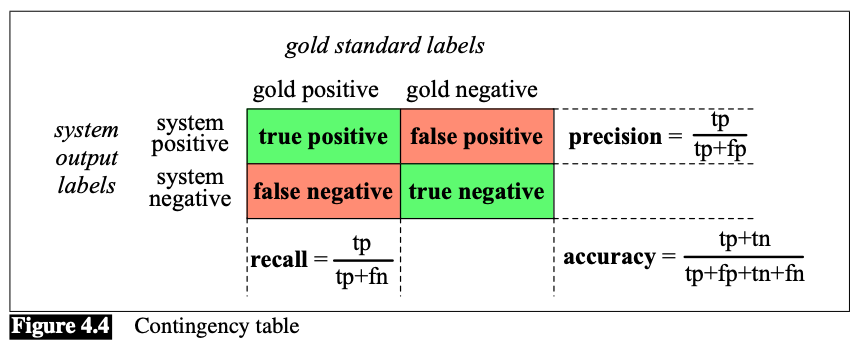

* $TP$: przykłady prawdziwie pozytywne,
* $FP$: przykłady fałszywie pozytywne,
* $FN$: przykłady fałszywie negatywne,
* $TN$: przykłady prawdziwie negatywne.


### Accuracy (dokładność)

Odsetek instancji, którym klasyfikator przypisał prawidłową kategorię.

$A = \frac{\mathit{TP+TN}}{\mathit{TP+FP+TN+FN}} = \frac{\mathit{\#correct}}{\mathit{\#total}}$


In [38]:
from sklearn.metrics import accuracy_score

print(accuracy_score([1, 2, 3, 2, 1], [1, 2, 3, 4, 5]))

0.6


### Precision, recall i F-mesure


**Precision** to ddsetek instancji wykrytych przez system, które są rzeczywiście poprawne.

$P = \frac{\mathit{TP}}{TP+FP}$

**Recall** to odsetek instancji w danych wejściowych, które zostały poprawnie zidentyfikowane przez system.

$R = \frac{\mathit{TP}}{TP+FN}$

**F(1)-measure** to średnia harmoniczna wartości precision i recall:

$F = \frac{2PR}{P + R}$


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_gold = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

for metric in (accuracy_score, precision_score, recall_score, f1_score):
    print('{:16} {:.2f}'.format(metric.__name__, metric(y_gold, y_pred)))

accuracy_score   0.80
precision_score  1.00
recall_score     0.50
f1_score         0.67


In [40]:
y_gold = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
y_pred = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

for metric in (accuracy_score, precision_score, recall_score, f1_score):
    print('{:16} {:.2f}'.format(metric.__name__, metric(y_gold, y_pred)))

accuracy_score   0.70
precision_score  0.57
recall_score     1.00
f1_score         0.73


### Klasyfikacja wieloklasowa (*multiclass classification*)


#### Micro

Zliczamy $TP$, $FP$ i $FN$ globalnie dla wszystkich danych. W ten sposób każda instancja ma taki sam wpływ na wynik końcowy. Każdy przykład zaklasyfikowany niepoprawnie jest uznawany jednocześnie za $FP$ i $FN$.

$TP =\mathit{\#correct}$

$FP = FN = \mathit{\#total} - \mathit{\#correct}$

W efekcie precision, recall i F-measure w wersji micro są równe sobie nawzajem i mierze accuracy:

$P_{mic} = \frac{TP}{TP + FP} = \frac{\mathit{\#correct}}{\mathit{\#total}} = A$

$R_{mic} = \frac{TP}{TP + FN} = \frac{\mathit{\#correct}}{\mathit{\#total}} = A$

$F_{mic} = \frac{2 P_{mic}R_{mic}}{P_{mic}+R_{mic}} = \frac{2 A^2}{2A} = A$

In [41]:
y_gold = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
y_pred = [0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 0, 0]

print(accuracy_score(y_gold, y_pred))
print(precision_score(y_gold, y_pred, average="micro"))
print(recall_score(y_gold, y_pred, average="micro"))
print(f1_score(y_gold, y_pred, average="micro"))

0.5833333333333334
0.5833333333333334
0.5833333333333334
0.5833333333333334


#### Macro

Obliczamy miary precision, recall i F-measure dla każdej klasy osobno i obliczamy ich średnie (standardowo nieważone, możliwy jest również wariant ważony, aby zmniejszyć wpływ mniej reprezentowanych klas na wynik).

In [42]:
y_gold = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
y_pred = [0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 0, 0]

print(accuracy_score(y_gold, y_pred))
print(precision_score(y_gold, y_pred, average="macro"))
print(recall_score(y_gold, y_pred, average="macro"))
print(f1_score(y_gold, y_pred, average="macro"))

0.5833333333333334
0.611111111111111
0.5833333333333334
0.580952380952381


### Tablica pomyłek (ang. confusion matrix)

Macierz zliczająca, ile razy instancję klasy X zaklasyfikowano jako klasę Y. Wartości na przekątnej odpowiadają prawidłowym klasyfikacjom.

W przykładzie poniżej kolejne wiersze macierzy należy odczytywać następująco:
 * **3** razy zaklasyfikowano 0 jako 0, **1** raz zaklasyfikowano 0 jako 1, **0** razy zaklasyfikowano 0 jako 2;
 * **1** raz zaklasyfikowano 1 jako 0, **2** razy zaklasyfikowano 1 jako 1, **1** raz zaklasyfikowano 1 jako 2;
 * **2** razy zaklasyfikowano 2 jako 0, **1** raz zaklasyfikowano 2 jako 1, **1** raz zaklasyfikowano 2 jako 2;
 

In [43]:
from sklearn.metrics import confusion_matrix

y_gold = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
y_pred = [0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 1]

print(confusion_matrix(y_gold, y_pred))

[[3 1 0]
 [1 2 1]
 [2 1 1]]


## Zadanie 1: Ewaluacja tagerów
Zaimplementuj ewaluację wydajnościową (czas predykcji) oraz jakościową (wykorzystaj poznane miary ewaluacyjne) uniwersalnych tagów (UPOS) i lematów (LEMMA) zwróconych przez modele spaCy (pl_core_news_sm) i COMBO. Wykorzystaj wzorcowy zbiór testowy http://mozart.ipipan.waw.pl/~alina/zasoby/data/PDBUD_test.conllu. Ponieważ nie testujemy jakości segmentacji i nie chcemy, żeby błędna segmentacja miała wpływ na jakość predykcji tagów i lematów, to segmentacja zdań w plikach wejściowych powinna być zgodna z segmentacją PDBUD_test.conllu.

(nie testujemy modelu morfeuszowego spaCy, bo on nie akceptuje wstępnie posegmentowanego wejścia)